In [1]:
#import numpy as np
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from collections import Counter
import os
import zipfile
import shutil
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
import random
!pip install tensorflow[and-cuda]==2.18 


2024-12-09 01:15:54.105033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733724954.123296  135884 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733724954.131556  135884 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 01:15:54.153316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Defaulting to user installation because normal site-packages is not writeable


In [2]:
def process_images_with_tf(image_paths, labels, images_mmap_path, labels_mmap_path, batch_size=500):
    total_images = len(image_paths)
    print(f"\nProcessing {total_images} images for memory-mapped storage...")

    # Define image shape and dtype for memory-mapped storage
    image_shape = (256, 256, 3)
    dtype = 'float32'

    # Create memory-mapped arrays for images and labels
    images_mmap = np.memmap(images_mmap_path, dtype=dtype, mode='w+', shape=(total_images, *image_shape))
    labels_mmap = np.memmap(labels_mmap_path, dtype='int32', mode='w+', shape=(total_images,))

    # Create TensorFlow dataset from image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Function to load and preprocess images
    def _load_and_preprocess_image(file_path, label):
        try:
            # Read and preprocess image
            img = tf.io.read_file(file_path)
            img = tf.io.decode_image(img, channels=3, expand_animations=False)
            img = tf.image.resize(img, [256, 256])
            img = tf.cast(img, tf.float32) / 255.0
            return img, label
        except Exception as e:
            # Log errors and return placeholder image
            print(f"Error processing image {file_path}: {e}")
            img = tf.zeros([256, 256, 3], dtype=tf.float32)
            return img, label

    # Optimize dataset pipeline
    dataset = dataset.map(_load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    idx = 0
    for batch_imgs, batch_labels in tqdm(dataset, total=(total_images + batch_size - 1) // batch_size, desc="Processing Images"):
        try:
            # Convert batch to NumPy and write to memory-mapped storage
            batch_imgs_np = batch_imgs.numpy()
            batch_labels_np = batch_labels.numpy()
            batch_size_actual = batch_imgs_np.shape[0]
            images_mmap[idx:idx + batch_size_actual] = batch_imgs_np
            labels_mmap[idx:idx + batch_size_actual] = batch_labels_np
            idx += batch_size_actual

            # Flush changes to disk and manage memory
            images_mmap.flush()
            labels_mmap.flush()
        except Exception as e:
            print(f"Error processing batch starting at index {idx}: {e}")
        finally:
            gc.collect()  # Ensure memory cleanup

    # Cleanup resources
    del images_mmap
    del labels_mmap
    print(f"Finished processing {total_images} images into {images_mmap_path} and {labels_mmap_path}.")


In [3]:
# --------------------- Helper Functions ---------------------

def is_image_file(filename):
    """
    Check if a file is an image based on its extension.
    
    Parameters:
    - filename (str): Name of the file.
    
    Returns:
    - bool: True if the file is an image, False otherwise.
    """
    return filename.lower().endswith(('.jpg', '.jpeg', '.png'))

# --------------------- Main Processing Function ---------------------

def main():
    """
    Main function to process images from 'D' and 'P' folders within 'SDNET2018.zip'.
    It samples a fraction of images from each subfolder, assigns labels, processes images,
    and saves them into separate memory-mapped files.
    """
    zip_path = 'SDNET2018.zip'  # Path to your zip file
    batch_size = 500  # Adjust based on available memory

    # Define mapping from subfolders to labels
    subfolder_label_mapping = {
        'SDNET2018/D/UD': 0,  # Uncracked
        'SDNET2018/D/CD': 1,  # Cracked
        'SDNET2018/P/UP': 0,  # Uncracked
        'SDNET2018/P/CP': 1   # Cracked
    }

    # Extract all filenames from the zip file
    print(f"Opening zip file: {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        all_filenames = zip_ref.namelist()

    # Helper to filter image filenames from a specific subfolder
    def get_image_filenames(subfolder):
        prefix = subfolder + '/'
        return [f for f in all_filenames if f.startswith(prefix) and is_image_file(f)]

    # Initialize dictionaries to hold image paths and labels for D and P
    data = {
        'D': {'image_paths': [], 'labels': []},
        'P': {'image_paths': [], 'labels': []}
    }

    # Iterate over each subfolder and process images
    for subfolder, label in tqdm(subfolder_label_mapping.items(), desc="Processing Subfolders"):
        image_filenames = get_image_filenames(subfolder)
        total_images = len(image_filenames)

        if total_images == 0:
            logging.warning(f"No images found in subfolder '{subfolder}'. Skipping.")
            continue

        sample_size = max(1, int(total_images * SAMPLE_FRACTION))  # Ensure at least 1 image is sampled
        sampled_filenames = random.sample(image_filenames, sample_size)

        print(f"\nFound {total_images} images in subfolder '{subfolder}'. Sampling {sample_size} images for label {label}.")

        # Extract images and assign labels
        image_paths, labels = extract_images_and_labels(zip_path, sampled_filenames, TEMP_DIR, label)

        # Determine main folder (D or P) based on subfolder
        main_folder = subfolder.split('/')[1]

        # Append to the respective main folder's data
        data[main_folder]['image_paths'].extend(image_paths)
        data[main_folder]['labels'].extend(labels)

    # Process and save D folder data
    if data['D']['image_paths']:
        print("\nProcessing 'D' folder...")
        process_images_with_tf(
            data['D']['image_paths'],
            labels=data['D']['labels'],
            images_mmap_path=IMAGES_D_MEMMAP_PATH,
            labels_mmap_path=LABELS_D_MEMMAP_PATH,
            batch_size=batch_size
        )
        # Save the filenames and labels for D
        np.save('filenames_d.npy', data['D']['image_paths'])
        np.save('labels_d.npy', data['D']['labels'])
    else:
        logging.warning("\nNo images found for 'D' folder after sampling.")

    # Process and save P folder data
    if data['P']['image_paths']:
        print("\nProcessing 'P' folder...")
        process_images_with_tf(
            data['P']['image_paths'],
            labels=data['P']['labels'],
            images_mmap_path=IMAGES_P_MEMMAP_PATH,
            labels_mmap_path=LABELS_P_MEMMAP_PATH,
            batch_size=batch_size
        )
        # Save the filenames and labels for P
        np.save('filenames_p.npy', data['P']['image_paths'])
        np.save('labels_p.npy', data['P']['labels'])
    else:
        logging.warning("\nNo images found for 'P' folder after sampling.")

    # Clear temporary directory
    print("\nCleaning up temporary files...")
    shutil.rmtree(TEMP_DIR, ignore_errors=True)
    os.makedirs(TEMP_DIR, exist_ok=True)

    # Free up memory
    del data
    gc.collect()

    print("\nProcessing complete. Filenames and labels saved for 'D' and 'P' folders.")


In [4]:
import os
import numpy as np
import logging
from sklearn.model_selection import train_test_split

# Paths for memory-mapped files after processing images
IMAGES_D_MEMMAP_PATH = 'images_d_mmap.npy'
LABELS_D_MEMMAP_PATH = 'labels_d.npy'
IMAGES_P_MEMMAP_PATH = 'images_p_mmap.npy'
LABELS_P_MEMMAP_PATH = 'labels_p.npy'

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ensure that necessary files exist
required_files = [IMAGES_D_MEMMAP_PATH, LABELS_D_MEMMAP_PATH, IMAGES_P_MEMMAP_PATH, LABELS_P_MEMMAP_PATH]
missing_files = [file for file in required_files if not os.path.exists(file)]
if missing_files:
    logging.error(f"Missing required files: {missing_files}. Ensure image extraction and processing were completed.")
    exit()

# Load labels
labels_d = np.load(LABELS_D_MEMMAP_PATH)
labels_p = np.load(LABELS_P_MEMMAP_PATH)

# Load images
total_images_d = len(labels_d)
total_images_p = len(labels_p)

images_d = np.memmap(IMAGES_D_MEMMAP_PATH, dtype='float32', mode='r', shape=(total_images_d, 256, 256, 3))
images_p = np.memmap(IMAGES_P_MEMMAP_PATH, dtype='float32', mode='r', shape=(total_images_p, 256, 256, 3))

# Verify label counts
if total_images_d != len(labels_d) or total_images_p != len(labels_p):
    logging.error("Mismatch in the number of images and labels.")
    exit()

logging.info("Data loaded successfully.")

# Further operations (splitting data, saving datasets)...


2024-12-09 01:16:01,634 - INFO - Data loaded successfully.


In [5]:

'''
# Load the datasets
train_images_A = np.load('train_set_A_images.npy')
train_labels_A = np.load('train_set_A_labels.npy')

train_images_B = np.load('train_set_B_images.npy')
train_labels_B = np.load('train_set_B_labels.npy')

train_images_C = np.load('train_set_C_images.npy')
train_labels_C = np.load('train_set_C_labels.npy')

test_images_D = np.load('test_set_D_images.npy')
test_labels_D = np.load('test_set_D_labels.npy')

test_images_P = np.load('test_set_P_images.npy')
test_labels_P = np.load('test_set_P_labels.npy')
'''

"\n# Load the datasets\ntrain_images_A = np.load('train_set_A_images.npy')\ntrain_labels_A = np.load('train_set_A_labels.npy')\n\ntrain_images_B = np.load('train_set_B_images.npy')\ntrain_labels_B = np.load('train_set_B_labels.npy')\n\ntrain_images_C = np.load('train_set_C_images.npy')\ntrain_labels_C = np.load('train_set_C_labels.npy')\n\ntest_images_D = np.load('test_set_D_images.npy')\ntest_labels_D = np.load('test_set_D_labels.npy')\n\ntest_images_P = np.load('test_set_P_images.npy')\ntest_labels_P = np.load('test_set_P_labels.npy')\n"

In [6]:
'''
# Define function to print class distributions
def print_class_distribution(labels, set_name):
    class_counts = Counter(labels)
    print(f"Class distribution for {set_name}: {dict(class_counts)}")

# Print class distributions for each training and test set
print_class_distribution(train_labels_A, "Train Set A (Large and Diverse)")
print_class_distribution(train_labels_B, "Train Set B (Small and Diverse)")
print_class_distribution(train_labels_C, "Train Set C (D only)")

print_class_distribution(test_labels_D, "Test Set D (D only)")
print_class_distribution(test_labels_P, "Test Set P (P only)")
'''

'\n# Define function to print class distributions\ndef print_class_distribution(labels, set_name):\n    class_counts = Counter(labels)\n    print(f"Class distribution for {set_name}: {dict(class_counts)}")\n\n# Print class distributions for each training and test set\nprint_class_distribution(train_labels_A, "Train Set A (Large and Diverse)")\nprint_class_distribution(train_labels_B, "Train Set B (Small and Diverse)")\nprint_class_distribution(train_labels_C, "Train Set C (D only)")\n\nprint_class_distribution(test_labels_D, "Test Set D (D only)")\nprint_class_distribution(test_labels_P, "Test Set P (P only)")\n'

In [7]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from collections import Counter

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Updated data generator function
def create_data_generator(images, labels, batch_size=16, shuffle=True, augment=True):
    images = images.astype('float32')
    labels = labels.astype('int64')

    def generator():
        indices = np.arange(len(images))
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, len(images), batch_size):
            end = min(start + batch_size, len(images))
            batch_indices = indices[start:end]
            batch_images = images[batch_indices]
            batch_labels = labels[batch_indices]
            
            if augment:
                batch_images = data_augmentation(batch_images)
            
            yield tf.convert_to_tensor(batch_images, dtype=tf.float32), tf.convert_to_tensor(batch_labels, dtype=tf.int64)

    output_signature = (
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int64)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

# Load datasets
train_images_A = np.load('train_set_A_images.npy')
train_labels_A = np.load('train_set_A_labels.npy')

train_images_B = np.load('train_set_B_images.npy')
train_labels_B = np.load('train_set_B_labels.npy')

train_images_C = np.load('train_set_C_images.npy')
train_labels_C = np.load('train_set_C_labels.npy')

test_images_D = np.load('test_set_D_images.npy')
test_labels_D = np.load('test_set_D_labels.npy')

test_images_P = np.load('test_set_P_images.npy')
test_labels_P = np.load('test_set_P_labels.npy')

print("Datasets loaded successfully.")

# Create generators for training and testing
train_gen_A = create_data_generator(train_images_A, train_labels_A, batch_size=16, shuffle=True, augment=True)
train_gen_B = create_data_generator(train_images_B, train_labels_B, batch_size=16, shuffle=True, augment=True)
train_gen_C = create_data_generator(train_images_C, train_labels_C, batch_size=16, shuffle=True, augment=True)

test_gen_D = create_data_generator(test_images_D, test_labels_D, batch_size=16, shuffle=False, augment=False)
test_gen_P = create_data_generator(test_images_P, test_labels_P, batch_size=16, shuffle=False, augment=False)

print("Data generators created successfully.")


I0000 00:00:1733724962.311713  135884 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38103 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


Datasets loaded successfully.
Data generators created successfully.


In [8]:
#from sklearn.utils.class_weight import compute_class_weight


In [9]:
'''def get_class_weights(labels):
    class_count = Counter(labels)
    total = sum(class_count.values())
    class_weights = {label: total / (len(class_count) * count) for label, count in class_count.items()}
    return class_weights
'''

'def get_class_weights(labels):\n    class_count = Counter(labels)\n    total = sum(class_count.values())\n    class_weights = {label: total / (len(class_count) * count) for label, count in class_count.items()}\n    return class_weights\n'

In [10]:
'''# Data Augmentation Pipeline using Keras Layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Updated Data Generator Function
def create_data_generator(images, labels, batch_size=16, shuffle=True, augment=True):
    images = images.astype('float32')
    labels = labels.astype('int64')

    def generator():
        indices = np.arange(len(images))
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, len(images), batch_size):
            end = min(start + batch_size, len(images))
            batch_indices = indices[start:end]
            batch_images = images[batch_indices]
            batch_labels = labels[batch_indices]
            
            if augment:
                batch_images = data_augmentation(batch_images)
            
            yield tf.convert_to_tensor(batch_images, dtype=tf.float32), tf.convert_to_tensor(batch_labels, dtype=tf.int64)

    output_signature = (
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int64)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

# Create Generators for Training and Testing
train_gen_A = create_data_generator(train_images_A, train_labels_A, batch_size=16, shuffle=True, augment=True)
train_gen_B = create_data_generator(train_images_B, train_labels_B, batch_size=16, shuffle=True, augment=True)
train_gen_C = create_data_generator(train_images_C, train_labels_C, batch_size=16, shuffle=True, augment=True)
# For the test generator, set shuffle=False and augment=False
test_gen_D = create_data_generator(test_images_D, test_labels_D, batch_size=16, shuffle=False, augment=False)
test_gen_P= create_data_generator(test_images_P, test_labels_P, batch_size=16, shuffle=False, augment=False)
# Calculate the number of steps for the test generator
num_test_samples = len(test_images_D)
test_steps = np.ceil(num_test_samples / 16).astype(int)'''

'# Data Augmentation Pipeline using Keras Layers\ndata_augmentation = tf.keras.Sequential([\n    tf.keras.layers.RandomFlip("horizontal_and_vertical"),\n    tf.keras.layers.RandomRotation(0.1),\n    tf.keras.layers.RandomZoom(0.1)\n])\n\n# Updated Data Generator Function\ndef create_data_generator(images, labels, batch_size=16, shuffle=True, augment=True):\n    images = images.astype(\'float32\')\n    labels = labels.astype(\'int64\')\n\n    def generator():\n        indices = np.arange(len(images))\n        if shuffle:\n            np.random.shuffle(indices)\n        for start in range(0, len(images), batch_size):\n            end = min(start + batch_size, len(images))\n            batch_indices = indices[start:end]\n            batch_images = images[batch_indices]\n            batch_labels = labels[batch_indices]\n            \n            if augment:\n                batch_images = data_augmentation(batch_images)\n            \n            yield tf.convert_to_tensor(batch_images, dt

In [11]:
from collections import Counter

def get_class_weights(labels):
    """
    Calculate class weights to handle class imbalance in datasets.

    Parameters:
    - labels (np.ndarray): Array of class labels.

    Returns:
    - dict: Dictionary of class weights {class: weight}.
    """
    class_count = Counter(labels)
    total = sum(class_count.values())
    class_weights = {label: total / (len(class_count) * count) for label, count in class_count.items()}
    return class_weights


In [12]:

'''
class_weights = get_class_weights(train_labels_A)
class_weights
adjustment_factor = 0.5  # Adjust this factor between 0 and 1
class_weights[1] = class_weights[1] * adjustment_factor
print("Adjusted class weights:", class_weights)'''

# Assuming train_labels_A is already loaded
train_labels_A = np.load('train_set_A_labels.npy')

# Calculate initial class weights
class_weights = get_class_weights(train_labels_A)
print("Original class weights:", class_weights)

# Adjust class weights for specific classes
adjustment_factor = 0.5  # Adjust this factor between 0 and 1
if 1 in class_weights:  # Ensure the class exists in the labels
    class_weights[1] = class_weights[1] * adjustment_factor

print("Adjusted class weights:", class_weights)


Original class weights: {0: 0.5580400690327906, 1: 4.807369101486748}
Adjusted class weights: {0: 0.5580400690327906, 1: 2.403684550743374}


In [13]:
# For training sets
num_train_samples_A = len(train_labels_A)
num_train_samples_B = len(train_labels_B)
num_train_samples_C = len(train_labels_C)

# For test sets
num_test_samples_D = len(test_labels_D)
num_test_samples_P = len(test_labels_P)


batch_size=16

steps_per_epoch_A = np.ceil(num_train_samples_A / batch_size).astype(int)
steps_per_epoch_B = np.ceil(num_train_samples_B / batch_size).astype(int)
steps_per_epoch_C = np.ceil(num_train_samples_C / batch_size).astype(int)

validation_steps_D = np.ceil(num_test_samples_D / batch_size).astype(int)
validation_steps_P = np.ceil(num_test_samples_P / batch_size).astype(int)


In [14]:
from tensorflow.keras import backend as K

def focal_loss(alpha=1, gamma=0):
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Compute cross-entropy loss
        ce_loss = - (y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

        # Compute the focal loss scaling factor
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        focal_factor = K.pow(1 - p_t, gamma)

        # Compute the focal loss
        focal_loss = alpha * focal_factor * ce_loss

        # Return the mean loss over the batch
        return K.mean(focal_loss)
    focal_loss_fixed.__name__ = 'focal_loss_fixed'  # Important to set the name
    return focal_loss_fixed

In [15]:
from tensorflow.keras.applications import ResNet50


In [19]:
'''def train_and_evaluate(
    train_gen,
    test_gen,
    train_labels,
    test_labels,
    set_name,
    batch_size=16,
    alpha=1,
    gamma=0
):
    # Load VGG16 pre-trained model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False

    # Build transfer learning model
    model_transfer = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the Model with Custom Focal Loss
    model_transfer.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005),
        loss=focal_loss(alpha=alpha, gamma=gamma),
        metrics=['accuracy']
    )

    # Define Callbacks
    callbacks_transfer = [
        tf.keras.callbacks.ModelCheckpoint(
            f'best_model_transfer_{set_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            verbose=1,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=2,
            verbose=1
        )
    ]

    # Train the Model
    history_transfer = model_transfer.fit(
        train_gen,
        validation_data=test_gen,
        epochs=1,  # Adjust as needed
        callbacks=callbacks_transfer,
        verbose=1
    )

    # Unfreeze Layers for Fine-tuning
    base_model.trainable = True

    # Recompile the Model
    model_transfer.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss=focal_loss(alpha=alpha, gamma=gamma),
        metrics=['accuracy']
    )
    
   

    # Fine-tune the Model
    history_fine_tune = model_transfer.fit(
        train_gen,
        validation_data=test_gen,
        epochs=5,  # Adjust as needed
        callbacks=callbacks_transfer,
        verbose=1
    )

    # Load the Best Model
    best_model = tf.keras.models.load_model(
        f'best_model_transfer_{set_name}.keras',
        custom_objects={'focal_loss_fixed': focal_loss(alpha=alpha, gamma=gamma)}
    )

    # Evaluate on test set
    num_test_samples = len(test_labels)
    validation_steps = np.ceil(num_test_samples / batch_size).astype(int)

    predictions = best_model.predict(test_gen, steps=validation_steps)
    predicted_labels = (predictions >= 0.15).astype(int).flatten()

    # Compute and print confusion matrix and metrics
    cm = confusion_matrix(test_labels[:len(predicted_labels)], predicted_labels)
    precision = precision_score(test_labels[:len(predicted_labels)], predicted_labels, zero_division=0)
    recall = recall_score(test_labels[:len(predicted_labels)], predicted_labels, zero_division=0)
    report = classification_report(
        test_labels[:len(predicted_labels)],
        predicted_labels,
        target_names=['Uncracked', 'Cracked'],
        zero_division=0
    )

    print(f"Confusion Matrix (Test Set {set_name}):")
    print(cm)
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Uncracked (0)', 'Cracked (1)'],
        yticklabels=['Uncracked (0)', 'Cracked (1)']
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix (Test Set {set_name})')
    plt.show()'''


# Import necessary libraries
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def train_and_evaluate(
    train_gen,
    test_gen,
    train_labels,
    test_labels,
    set_name,
    batch_size=16,
    alpha=1,
    gamma=0
):
    # Load VGG16 pre-trained model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False

    # Build transfer learning model
    model_transfer = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the Model with Custom Focal Loss
    model_transfer.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005),
        loss=focal_loss(alpha=alpha, gamma=gamma),
        metrics=['accuracy']
    )

    # Augment Training Data
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ])
    train_gen = train_gen.map(lambda x, y: (data_augmentation(x), y))

    # Compute Class Weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Define Callbacks
    callbacks_transfer = [
        tf.keras.callbacks.ModelCheckpoint(
            f'best_model_transfer_{set_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            verbose=1,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=2,
            verbose=1
        )
    ]

    # Train the Model
    history_transfer = model_transfer.fit(
        train_gen,
        validation_data=test_gen,
        epochs=10,  # Adjust epochs as needed
        callbacks=callbacks_transfer,
        class_weight=class_weights_dict,
        verbose=1
    )

    # Rest of the function remains unchanged...


    # Unfreeze Layers for Fine-tuning
    for layer in base_model.layers[-10:]:  # Fine-tune the top layers only
        layer.trainable = True

    # Recompile the Model
    model_transfer.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss=focal_loss(alpha=alpha, gamma=gamma),
        metrics=['accuracy']
    )

    # Fine-tune the Model
    history_fine_tune = model_transfer.fit(
        train_gen,
        validation_data=test_gen,
        epochs=5,  # Adjust as needed
        callbacks=callbacks_transfer,
        verbose=1
    )

    # Load the Best Model
    best_model = tf.keras.models.load_model(
        f'best_model_transfer_{set_name}.keras',
        custom_objects={'focal_loss_fixed': focal_loss(alpha=alpha, gamma=gamma)}
    )

    # Evaluate on test set
    num_test_samples = len(test_labels)
    validation_steps = np.ceil(num_test_samples / batch_size).astype(int)
    predictions = best_model.predict(test_gen, steps=validation_steps)

    # Optimize Prediction Threshold
    from sklearn.metrics import precision_recall_curve

    def optimize_threshold(y_true, y_pred):
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        f1_scores = 2 * precision * recall / (precision + recall)
        optimal_idx = np.argmax(f1_scores)
        return thresholds[optimal_idx]

    optimal_threshold = optimize_threshold(test_labels, predictions)
    print(f"Optimal Threshold: {optimal_threshold:.2f}")

    predicted_labels = (predictions >= optimal_threshold).astype(int).flatten()

    # Compute and print confusion matrix and metrics
    cm = confusion_matrix(test_labels[:len(predicted_labels)], predicted_labels)
    precision = precision_score(test_labels[:len(predicted_labels)], predicted_labels, zero_division=0)
    recall = recall_score(test_labels[:len(predicted_labels)], predicted_labels, zero_division=0)
    report = classification_report(
        test_labels[:len(predicted_labels)],
        predicted_labels,
        target_names=['Uncracked', 'Cracked'],
        zero_division=0
    )

    print(f"Confusion Matrix (Test Set {set_name}):")
    print(cm)
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Uncracked (0)', 'Cracked (1)'],
        yticklabels=['Uncracked (0)', 'Cracked (1)']
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix (Test Set {set_name})')
    plt.show()

    # Plot ROC Curve
    from sklearn.metrics import roc_curve, auc

    def plot_roc_curve(y_true, y_pred):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    plot_roc_curve(test_labels, predictions)



In [20]:
# List of training generators and labels with their set names
training_sets = [
    {'name': 'A', 'gen': train_gen_A, 'labels': train_labels_A},
    {'name': 'B', 'gen': train_gen_B, 'labels': train_labels_B},
    {'name': 'C', 'gen': train_gen_C, 'labels': train_labels_C},
    # Add more training sets if available
]

# List of testing generators and labels with their set names
testing_sets = [
    {'name': 'D', 'gen': test_gen_D, 'labels': test_labels_D},
    {'name': 'P', 'gen': test_gen_P, 'labels': test_labels_P},
    # Add more testing sets if available
]


Training on set A and testing on set D
Epoch 1/10


I0000 00:00:1733725042.672870  136066 service.cc:148] XLA service 0x7f4b6400d640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733725042.672919  136066 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-12-09 01:17:22.706808: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733725042.908217  136066 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-09 01:17:24.817533: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


      9/Unknown 5s 14ms/step - accuracy: 0.8631 - loss: 0.5995

I0000 00:00:1733725045.266083  136066 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    930/Unknown 159s 167ms/step - accuracy: 0.8867 - loss: 0.4188

2024-12-09 01:20:00.318358: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-09 01:20:00.318457: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.90202, saving model to best_model_transfer_A_to_D.keras


2024-12-09 01:20:02.714132: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


930/930 ━━━━━━━━━━━━━━━━━━━━ 162s 170ms/step - accuracy: 0.8867 - loss: 0.4188 - val_accuracy: 0.9020 - val_loss: 0.2572 - learning_rate: 5.0000e-04
Epoch 2/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8952 - loss: 0.3691

2024-12-09 01:22:38.287303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1118476411542817906
2024-12-09 01:22:38.287406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 2: val_accuracy did not improve from 0.90202
930/930 ━━━━━━━━━━━━━━━━━━━━ 156s 168ms/step - accuracy: 0.8952 - loss: 0.3691 - val_accuracy: 0.9020 - val_loss: 0.2457 - learning_rate: 5.0000e-04
Epoch 3/10


2024-12-09 01:22:39.354203: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-09 01:22:39.354304: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 01:22:39.354320: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8946 - loss: 0.3565

2024-12-09 01:25:14.129016: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 01:25:14.129095: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1118476411542817906
2024-12-09 01:25:14.129119: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 3: val_accuracy did not improve from 0.90202

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
930/930 ━━━━━━━━━━━━━━━━━━━━ 156s 167ms/step - accuracy: 0.8946 - loss: 0.3565 - val_accuracy: 0.9020 - val_loss: 0.2709 - learning_rate: 5.0000e-04
Epoch 4/10


2024-12-09 01:25:15.130604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 01:25:15.130710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8977 - loss: 0.3355

2024-12-09 01:27:49.987486: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1118476411542817906
2024-12-09 01:27:49.987604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 4: val_accuracy did not improve from 0.90202
930/930 ━━━━━━━━━━━━━━━━━━━━ 156s 168ms/step - accuracy: 0.8977 - loss: 0.3355 - val_accuracy: 0.9020 - val_loss: 0.2351 - learning_rate: 2.5000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5


2024-12-09 01:27:51.010047: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-09 01:27:51.010157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 01:27:51.010173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


    930/Unknown 173s 180ms/step - accuracy: 0.9056 - loss: 0.2846

2024-12-09 01:30:44.180284: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 1: val_accuracy improved from 0.90202 to 0.94868, saving model to best_model_transfer_A_to_D.keras


2024-12-09 01:30:45.906286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 01:30:45.906385: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


930/930 ━━━━━━━━━━━━━━━━━━━━ 175s 182ms/step - accuracy: 0.9056 - loss: 0.2846 - val_accuracy: 0.9487 - val_loss: 0.1465 - learning_rate: 1.0000e-05
Epoch 2/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9329 - loss: 0.2196

2024-12-09 01:33:31.119305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 2: val_accuracy improved from 0.94868 to 0.95723, saving model to best_model_transfer_A_to_D.keras
930/930 ━━━━━━━━━━━━━━━━━━━━ 166s 179ms/step - accuracy: 0.9329 - loss: 0.2196 - val_accuracy: 0.9572 - val_loss: 0.1311 - learning_rate: 1.0000e-05
Epoch 3/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9400 - loss: 0.1935
Epoch 3: val_accuracy improved from 0.95723 to 0.96034, saving model to best_model_transfer_A_to_D.keras
930/930 ━━━━━━━━━━━━━━━━━━━━ 165s 178ms/step - accuracy: 0.9400 - loss: 0.1935 - val_accuracy: 0.9603 - val_loss: 0.1264 - learning_rate: 1.0000e-05
Epoch 4/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9434 - loss: 0.1974

2024-12-09 01:39:03.014286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 4: val_accuracy improved from 0.96034 to 0.96423, saving model to best_model_transfer_A_to_D.keras


2024-12-09 01:39:04.023346: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


930/930 ━━━━━━━━━━━━━━━━━━━━ 166s 179ms/step - accuracy: 0.9434 - loss: 0.1974 - val_accuracy: 0.9642 - val_loss: 0.1022 - learning_rate: 1.0000e-05
Epoch 5/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9475 - loss: 0.1752

2024-12-09 01:41:49.544433: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 5: val_accuracy improved from 0.96423 to 0.96579, saving model to best_model_transfer_A_to_D.keras
930/930 ━━━━━━━━━━━━━━━━━━━━ 167s 179ms/step - accuracy: 0.9475 - loss: 0.1752 - val_accuracy: 0.9658 - val_loss: 0.1021 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Optimal Threshold: 0.30
Confusion Matrix (Test Set A_to_D):
[[1145   15]
 [  25  101]]

Precision: 0.8707
Recall:    0.8016

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.98      0.99      0.98      1160
     Cracked       0.87      0.80      0.83       126

    accuracy                           0.97      1286
   macro avg       0.92      0.89      0.91      1286
weighted avg       0.97      0.97      0.97      1286



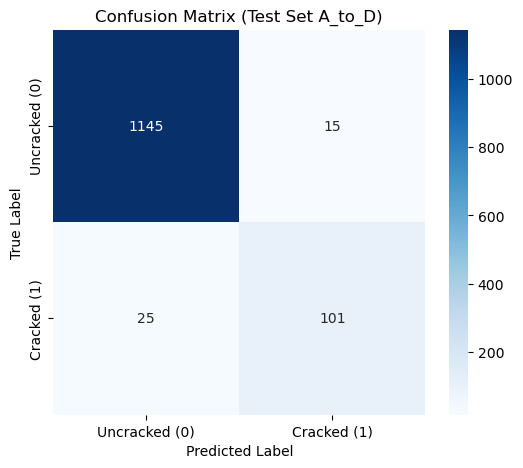

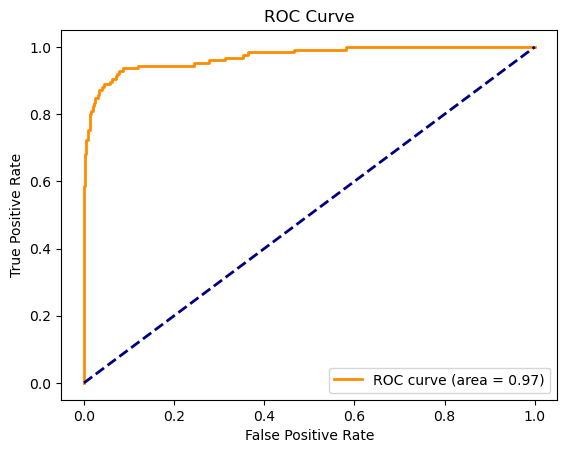


Training on set A and testing on set P
Epoch 1/10
    930/Unknown 158s 168ms/step - accuracy: 0.8818 - loss: 0.4647

2024-12-09 01:44:31.991214: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-12-09 01:44:31.991306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1118476411542817906
2024-12-09 01:44:31.991338: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 1: val_accuracy improved from -inf to 0.89277, saving model to best_model_transfer_A_to_P.keras


2024-12-09 01:44:35.608319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171


930/930 ━━━━━━━━━━━━━━━━━━━━ 162s 172ms/step - accuracy: 0.8818 - loss: 0.4646 - val_accuracy: 0.8928 - val_loss: 0.2772 - learning_rate: 5.0000e-04
Epoch 2/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8965 - loss: 0.3574

2024-12-09 01:47:12.118465: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171



Epoch 2: val_accuracy did not improve from 0.89277
930/930 ━━━━━━━━━━━━━━━━━━━━ 158s 170ms/step - accuracy: 0.8965 - loss: 0.3574 - val_accuracy: 0.8928 - val_loss: 0.2666 - learning_rate: 5.0000e-04
Epoch 3/10


2024-12-09 01:47:14.159782: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 01:47:14.159887: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8986 - loss: 0.3351
Epoch 3: val_accuracy did not improve from 0.89277

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
930/930 ━━━━━━━━━━━━━━━━━━━━ 157s 169ms/step - accuracy: 0.8986 - loss: 0.3351 - val_accuracy: 0.8928 - val_loss: 0.2587 - learning_rate: 5.0000e-04
Epoch 4/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8959 - loss: 0.3299
Epoch 4: val_accuracy did not improve from 0.89277
930/930 ━━━━━━━━━━━━━━━━━━━━ 158s 170ms/step - accuracy: 0.8959 - loss: 0.3299 - val_accuracy: 0.8928 - val_loss: 0.3000 - learning_rate: 2.5000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5


2024-12-09 01:52:29.703764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 01:52:29.703848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


    930/Unknown 167s 176ms/step - accuracy: 0.9151 - loss: 0.2767

2024-12-09 01:55:17.210666: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 01:55:17.210749: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 1: val_accuracy improved from 0.89277 to 0.94330, saving model to best_model_transfer_A_to_P.keras
930/930 ━━━━━━━━━━━━━━━━━━━━ 170s 180ms/step - accuracy: 0.9151 - loss: 0.2767 - val_accuracy: 0.9433 - val_loss: 0.1821 - learning_rate: 1.0000e-05
Epoch 2/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9380 - loss: 0.2193

2024-12-09 01:58:08.302058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 2: val_accuracy did not improve from 0.94330
930/930 ━━━━━━━━━━━━━━━━━━━━ 170s 183ms/step - accuracy: 0.9380 - loss: 0.2193 - val_accuracy: 0.9359 - val_loss: 0.1972 - learning_rate: 1.0000e-05
Epoch 3/5


2024-12-09 01:58:10.236923: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9433 - loss: 0.1961

2024-12-09 02:01:00.484480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 3: val_accuracy improved from 0.94330 to 0.94864, saving model to best_model_transfer_A_to_P.keras


2024-12-09 02:01:02.503417: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


930/930 ━━━━━━━━━━━━━━━━━━━━ 173s 186ms/step - accuracy: 0.9433 - loss: 0.1961 - val_accuracy: 0.9486 - val_loss: 0.1594 - learning_rate: 1.0000e-05
Epoch 4/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9414 - loss: 0.1934

2024-12-09 02:03:45.487924: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:03:45.488026: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 4: val_accuracy improved from 0.94864 to 0.94947, saving model to best_model_transfer_A_to_P.keras
930/930 ━━━━━━━━━━━━━━━━━━━━ 165s 177ms/step - accuracy: 0.9414 - loss: 0.1934 - val_accuracy: 0.9495 - val_loss: 0.1518 - learning_rate: 1.0000e-05
Epoch 5/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9442 - loss: 0.1958
Epoch 5: val_accuracy did not improve from 0.94947
930/930 ━━━━━━━━━━━━━━━━━━━━ 166s 178ms/step - accuracy: 0.9442 - loss: 0.1958 - val_accuracy: 0.9462 - val_loss: 0.1530 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 4.
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Optimal Threshold: 0.48
Confusion Matrix (Test Set A_to_P):
[[2125   48]
 [  75  186]]

Precision: 0.7949
Recall:    0.7126

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.97      0.98      0.97      2173
     Cracked       0.79      0.71      0.75       261

    accuracy                           0.95  

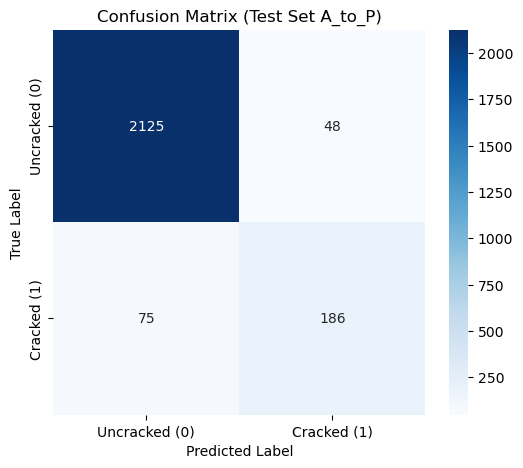

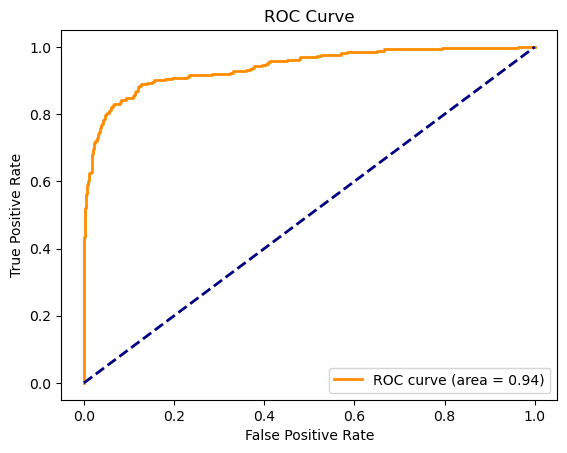


Training on set B and testing on set D
Epoch 1/10
     93/Unknown 18s 179ms/step - accuracy: 0.8674 - loss: 0.6793

2024-12-09 02:06:55.776317: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.90202, saving model to best_model_transfer_B_to_D.keras


2024-12-09 02:06:57.427454: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:06:57.427543: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.8674 - loss: 0.6781 - val_accuracy: 0.9020 - val_loss: 0.2893 - learning_rate: 5.0000e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8823 - loss: 0.4377
Epoch 2: val_accuracy did not improve from 0.90202
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - accuracy: 0.8823 - loss: 0.4377 - val_accuracy: 0.9020 - val_loss: 0.2773 - learning_rate: 5.0000e-04
Epoch 3/10


2024-12-09 02:07:14.216672: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:07:14.216761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8911 - loss: 0.3948
Epoch 3: val_accuracy did not improve from 0.90202

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.8910 - loss: 0.3950 - val_accuracy: 0.9020 - val_loss: 0.2859 - learning_rate: 5.0000e-04
Epoch 4/10


2024-12-09 02:07:32.705267: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:07:32.705364: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8896 - loss: 0.3805
Epoch 4: val_accuracy did not improve from 0.90202
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - accuracy: 0.8895 - loss: 0.3806 - val_accuracy: 0.9020 - val_loss: 0.2898 - learning_rate: 2.5000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5


2024-12-09 02:07:49.264584: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:07:49.264685: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


     93/Unknown 23s 215ms/step - accuracy: 0.8709 - loss: 0.3906
Epoch 1: val_accuracy did not improve from 0.90202
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.8711 - loss: 0.3904 - val_accuracy: 0.9020 - val_loss: 0.2513 - learning_rate: 1.0000e-05
Epoch 2/5


2024-12-09 02:08:14.127501: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8889 - loss: 0.3129
Epoch 2: val_accuracy improved from 0.90202 to 0.93002, saving model to best_model_transfer_B_to_D.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.8890 - loss: 0.3130 - val_accuracy: 0.9300 - val_loss: 0.2188 - learning_rate: 1.0000e-05
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9076 - loss: 0.2993
Epoch 3: val_accuracy did not improve from 0.93002
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.9076 - loss: 0.2995 - val_accuracy: 0.9230 - val_loss: 0.2139 - learning_rate: 1.0000e-05
Epoch 4/5


2024-12-09 02:08:49.649355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:08:49.649473: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9087 - loss: 0.3123
Epoch 4: val_accuracy improved from 0.93002 to 0.93857, saving model to best_model_transfer_B_to_D.keras


2024-12-09 02:09:07.177334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171


93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.9087 - loss: 0.3122 - val_accuracy: 0.9386 - val_loss: 0.2024 - learning_rate: 1.0000e-05
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9158 - loss: 0.2830
Epoch 5: val_accuracy improved from 0.93857 to 0.94168, saving model to best_model_transfer_B_to_D.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.9158 - loss: 0.2829 - val_accuracy: 0.9417 - val_loss: 0.1991 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Optimal Threshold: 0.06
Confusion Matrix (Test Set B_to_D):
[[1112   48]
 [  40   86]]

Precision: 0.6418
Recall:    0.6825

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.97      0.96      0.96      1160
     Cracked       0.64      0.68      0.66       126

    accuracy                           0.93      1286
   macro avg       0.80      0.82      0.81      1286

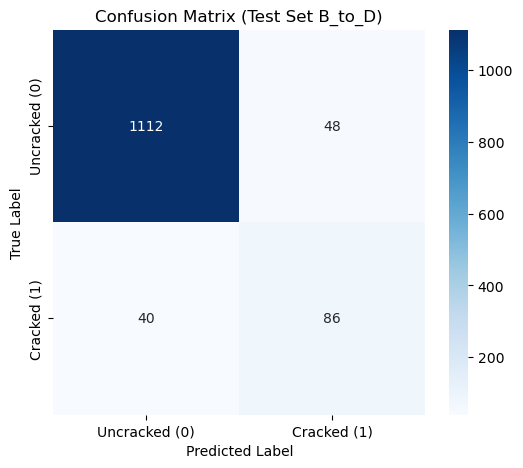

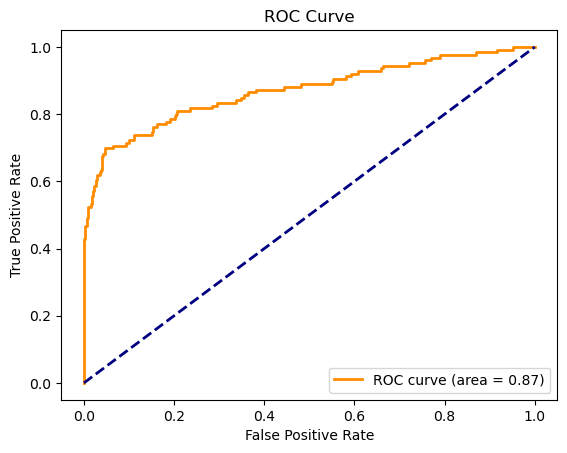


Training on set B and testing on set P
Epoch 1/10
     93/Unknown 17s 165ms/step - accuracy: 0.7888 - loss: 1.0302

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.89277, saving model to best_model_transfer_B_to_P.keras


2024-12-09 02:09:47.822242: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:09:47.822335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.7894 - loss: 1.0261 - val_accuracy: 0.8928 - val_loss: 0.3174 - learning_rate: 5.0000e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8800 - loss: 0.4064

2024-12-09 02:10:04.069936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1118476411542817906
2024-12-09 02:10:04.070053: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 2: val_accuracy did not improve from 0.89277
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.8801 - loss: 0.4065 - val_accuracy: 0.8928 - val_loss: 0.3690 - learning_rate: 5.0000e-04
Epoch 3/10


2024-12-09 02:10:07.332010: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:10:07.332104: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8822 - loss: 0.4044

2024-12-09 02:10:22.814735: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 3: val_accuracy did not improve from 0.89277

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.8822 - loss: 0.4044 - val_accuracy: 0.8928 - val_loss: 0.2879 - learning_rate: 5.0000e-04
Epoch 4/10


2024-12-09 02:10:24.828415: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:10:24.828509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8860 - loss: 0.3856
Epoch 4: val_accuracy did not improve from 0.89277
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.8860 - loss: 0.3855 - val_accuracy: 0.8928 - val_loss: 0.3011 - learning_rate: 2.5000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5
     93/Unknown 21s 190ms/step - accuracy: 0.8763 - loss: 0.3705

2024-12-09 02:11:03.067012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:11:03.067113: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 1: val_accuracy improved from 0.89277 to 0.90263, saving model to best_model_transfer_B_to_P.keras


2024-12-09 02:11:05.684506: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step - accuracy: 0.8765 - loss: 0.3701 - val_accuracy: 0.9026 - val_loss: 0.2597 - learning_rate: 1.0000e-05
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9140 - loss: 0.2832
Epoch 2: val_accuracy improved from 0.90263 to 0.91701, saving model to best_model_transfer_B_to_P.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - accuracy: 0.9139 - loss: 0.2833 - val_accuracy: 0.9170 - val_loss: 0.2440 - learning_rate: 1.0000e-05
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9101 - loss: 0.2794

2024-12-09 02:11:41.377745: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:11:41.377817: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 3: val_accuracy did not improve from 0.91701
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.9101 - loss: 0.2794 - val_accuracy: 0.9071 - val_loss: 0.2588 - learning_rate: 1.0000e-05
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9383 - loss: 0.2531

2024-12-09 02:11:59.643046: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:11:59.643146: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 4: val_accuracy did not improve from 0.91701

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.9382 - loss: 0.2533 - val_accuracy: 0.9051 - val_loss: 0.2553 - learning_rate: 1.0000e-05
Epoch 5/5


2024-12-09 02:12:01.570710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8994 - loss: 0.2857

2024-12-09 02:12:17.940608: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:12:17.940710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 5: val_accuracy improved from 0.91701 to 0.93221, saving model to best_model_transfer_B_to_P.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.8996 - loss: 0.2854 - val_accuracy: 0.9322 - val_loss: 0.2030 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 5.
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Optimal Threshold: 0.19
Confusion Matrix (Test Set B_to_P):
[[2088   85]
 [  94  167]]

Precision: 0.6627
Recall:    0.6398

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.96      0.96      0.96      2173
     Cracked       0.66      0.64      0.65       261

    accuracy                           0.93      2434
   macro avg       0.81      0.80      0.80      2434
weighted avg       0.93      0.93      0.93      2434



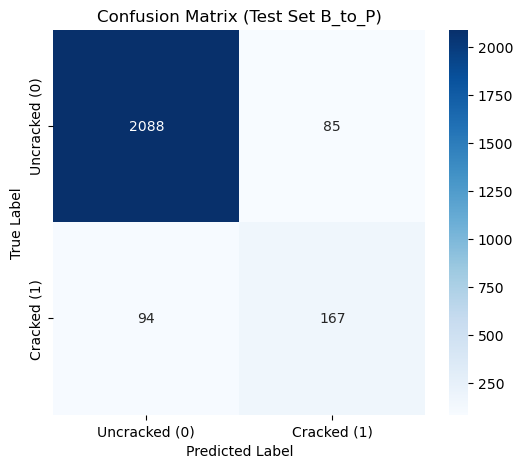

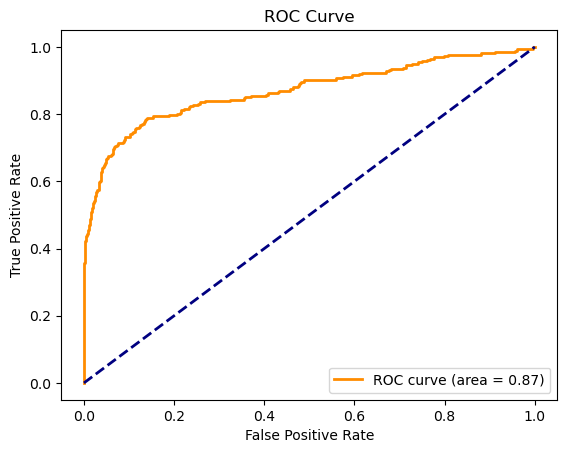


Training on set C and testing on set D
Epoch 1/10
    322/Unknown 56s 168ms/step - accuracy: 0.8797 - loss: 0.4640

2024-12-09 02:13:19.958550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-12-09 02:13:19.958642: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1118476411542817906
2024-12-09 02:13:19.958653: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 1: val_accuracy improved from -inf to 0.91680, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:13:21.607511: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 58s 174ms/step - accuracy: 0.8797 - loss: 0.4637 - val_accuracy: 0.9168 - val_loss: 0.2937 - learning_rate: 5.0000e-04
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9166 - loss: 0.3263

2024-12-09 02:14:15.408305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1118476411542817906
2024-12-09 02:14:15.408410: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 2: val_accuracy improved from 0.91680 to 0.92691, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:14:16.575329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:14:16.575414: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 55s 170ms/step - accuracy: 0.9166 - loss: 0.3263 - val_accuracy: 0.9269 - val_loss: 0.2334 - learning_rate: 5.0000e-04
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9141 - loss: 0.3322

2024-12-09 02:15:10.296663: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:15:10.296762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1118476411542817906
2024-12-09 02:15:10.296772: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 3: val_accuracy improved from 0.92691 to 0.92924, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:15:11.313477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 55s 170ms/step - accuracy: 0.9141 - loss: 0.3321 - val_accuracy: 0.9292 - val_loss: 0.2134 - learning_rate: 5.0000e-04
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9208 - loss: 0.3132

2024-12-09 02:16:05.913365: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:16:05.913484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1118476411542817906
2024-12-09 02:16:05.913494: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 4: val_accuracy improved from 0.92924 to 0.93002, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:16:06.920911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.9208 - loss: 0.3131 - val_accuracy: 0.9300 - val_loss: 0.2162 - learning_rate: 5.0000e-04
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9227 - loss: 0.2949
Epoch 5: val_accuracy improved from 0.93002 to 0.93468, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:17:01.775256: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 55s 170ms/step - accuracy: 0.9227 - loss: 0.2949 - val_accuracy: 0.9347 - val_loss: 0.2049 - learning_rate: 5.0000e-04
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9219 - loss: 0.3110

2024-12-09 02:17:55.217418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 6: val_accuracy did not improve from 0.93468
322/322 ━━━━━━━━━━━━━━━━━━━━ 54s 168ms/step - accuracy: 0.9219 - loss: 0.3110 - val_accuracy: 0.9316 - val_loss: 0.2080 - learning_rate: 5.0000e-04
Epoch 7/10


2024-12-09 02:17:56.323423: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9222 - loss: 0.3041
Epoch 7: val_accuracy did not improve from 0.93468

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
322/322 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - accuracy: 0.9222 - loss: 0.3041 - val_accuracy: 0.9339 - val_loss: 0.2052 - learning_rate: 5.0000e-04
Epoch 8/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9279 - loss: 0.2609

2024-12-09 02:19:45.139377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 8: val_accuracy improved from 0.93468 to 0.93779, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:19:46.239573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 55s 170ms/step - accuracy: 0.9279 - loss: 0.2609 - val_accuracy: 0.9378 - val_loss: 0.1923 - learning_rate: 2.5000e-04
Epoch 9/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9280 - loss: 0.2647
Epoch 9: val_accuracy improved from 0.93779 to 0.94090, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:20:41.268093: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - accuracy: 0.9280 - loss: 0.2647 - val_accuracy: 0.9409 - val_loss: 0.1852 - learning_rate: 2.5000e-04
Epoch 10/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9306 - loss: 0.2545
Epoch 10: val_accuracy did not improve from 0.94090
322/322 ━━━━━━━━━━━━━━━━━━━━ 55s 172ms/step - accuracy: 0.9306 - loss: 0.2545 - val_accuracy: 0.9386 - val_loss: 0.1818 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 9.
Epoch 1/5
    322/Unknown 63s 185ms/step - accuracy: 0.9354 - loss: 0.2401

2024-12-09 02:22:39.761721: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171



Epoch 1: val_accuracy improved from 0.94090 to 0.95412, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:22:41.414304: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:22:41.414411: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - accuracy: 0.9354 - loss: 0.2400 - val_accuracy: 0.9541 - val_loss: 0.1369 - learning_rate: 1.0000e-05
Epoch 2/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9362 - loss: 0.2076
Epoch 2: val_accuracy improved from 0.95412 to 0.95801, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:23:40.100459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 182ms/step - accuracy: 0.9363 - loss: 0.2075 - val_accuracy: 0.9580 - val_loss: 0.1248 - learning_rate: 1.0000e-05
Epoch 3/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9416 - loss: 0.2089
Epoch 3: val_accuracy improved from 0.95801 to 0.96034, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:24:38.754945: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:24:38.755052: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 182ms/step - accuracy: 0.9416 - loss: 0.2089 - val_accuracy: 0.9603 - val_loss: 0.1120 - learning_rate: 1.0000e-05
Epoch 4/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9480 - loss: 0.1888
Epoch 4: val_accuracy improved from 0.96034 to 0.96501, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:25:37.405546: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:25:37.405642: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 182ms/step - accuracy: 0.9480 - loss: 0.1888 - val_accuracy: 0.9650 - val_loss: 0.1049 - learning_rate: 1.0000e-05
Epoch 5/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9526 - loss: 0.1716
Epoch 5: val_accuracy improved from 0.96501 to 0.96656, saving model to best_model_transfer_C_to_D.keras


2024-12-09 02:26:36.000281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:26:36.000378: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 182ms/step - accuracy: 0.9525 - loss: 0.1716 - val_accuracy: 0.9666 - val_loss: 0.1033 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Optimal Threshold: 0.36
Confusion Matrix (Test Set C_to_D):
[[1153    7]
 [  34   92]]

Precision: 0.9293
Recall:    0.7302

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.97      0.99      0.98      1160
     Cracked       0.93      0.73      0.82       126

    accuracy                           0.97      1286
   macro avg       0.95      0.86      0.90      1286
weighted avg       0.97      0.97      0.97      1286



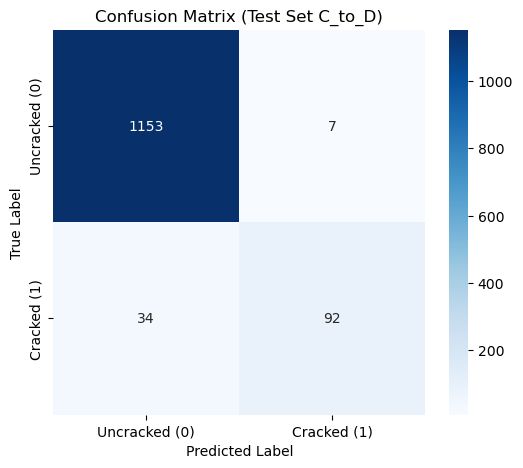

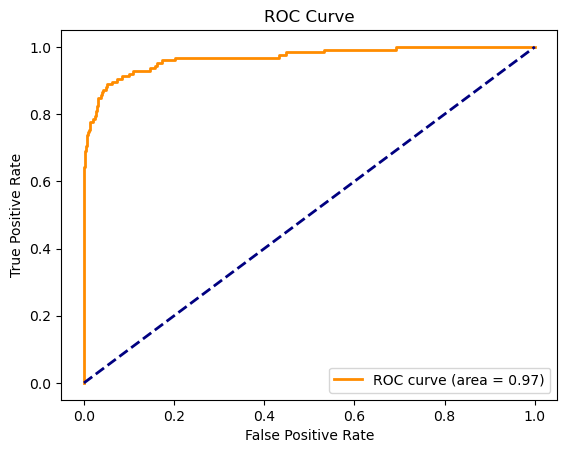


Training on set C and testing on set P
Epoch 1/10
    322/Unknown 55s 167ms/step - accuracy: 0.8919 - loss: 0.4325

2024-12-09 02:27:34.686524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-12-09 02:27:34.686610: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1118476411542817906
2024-12-09 02:27:34.686621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 1: val_accuracy improved from -inf to 0.89688, saving model to best_model_transfer_C_to_P.keras


2024-12-09 02:27:37.301909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:27:37.302011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 58s 176ms/step - accuracy: 0.8919 - loss: 0.4323 - val_accuracy: 0.8969 - val_loss: 0.3491 - learning_rate: 5.0000e-04
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9024 - loss: 0.3272
Epoch 2: val_accuracy improved from 0.89688 to 0.89729, saving model to best_model_transfer_C_to_P.keras


2024-12-09 02:28:33.164102: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:28:33.164196: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.9024 - loss: 0.3272 - val_accuracy: 0.8973 - val_loss: 0.2966 - learning_rate: 5.0000e-04
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9121 - loss: 0.3348
Epoch 3: val_accuracy did not improve from 0.89729
322/322 ━━━━━━━━━━━━━━━━━━━━ 56s 172ms/step - accuracy: 0.9121 - loss: 0.3348 - val_accuracy: 0.8952 - val_loss: 0.3416 - learning_rate: 5.0000e-04
Epoch 4/10


2024-12-09 02:29:29.010303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:29:29.010378: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9055 - loss: 0.3195
Epoch 4: val_accuracy improved from 0.89729 to 0.90427, saving model to best_model_transfer_C_to_P.keras


2024-12-09 02:30:24.522078: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:30:24.522172: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.9055 - loss: 0.3195 - val_accuracy: 0.9043 - val_loss: 0.3093 - learning_rate: 5.0000e-04
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9249 - loss: 0.2701
Epoch 5: val_accuracy did not improve from 0.90427
322/322 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.9249 - loss: 0.2702 - val_accuracy: 0.8981 - val_loss: 0.3700 - learning_rate: 5.0000e-04
Epoch 6/10


2024-12-09 02:31:20.411244: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:31:20.411333: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9174 - loss: 0.3068

2024-12-09 02:32:14.076257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171



Epoch 6: val_accuracy did not improve from 0.90427

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
322/322 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.9174 - loss: 0.3068 - val_accuracy: 0.9010 - val_loss: 0.3416 - learning_rate: 5.0000e-04
Epoch 7/10


2024-12-09 02:32:16.030458: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:32:16.030536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9193 - loss: 0.2751
Epoch 7: val_accuracy did not improve from 0.90427
322/322 ━━━━━━━━━━━━━━━━━━━━ 58s 173ms/step - accuracy: 0.9193 - loss: 0.2752 - val_accuracy: 0.8998 - val_loss: 0.3710 - learning_rate: 2.5000e-04
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 1/5


2024-12-09 02:33:13.639882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171


    322/Unknown 62s 182ms/step - accuracy: 0.9184 - loss: 0.2517

2024-12-09 02:34:15.810769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 1: val_accuracy improved from 0.90427 to 0.91044, saving model to best_model_transfer_C_to_P.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 65s 191ms/step - accuracy: 0.9184 - loss: 0.2516 - val_accuracy: 0.9104 - val_loss: 0.5922 - learning_rate: 1.0000e-05
Epoch 2/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9290 - loss: 0.2034

2024-12-09 02:35:15.961976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 2: val_accuracy improved from 0.91044 to 0.91660, saving model to best_model_transfer_C_to_P.keras


2024-12-09 02:35:17.782541: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:35:17.782641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.9290 - loss: 0.2034 - val_accuracy: 0.9166 - val_loss: 0.3304 - learning_rate: 1.0000e-05
Epoch 3/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9325 - loss: 0.2124

2024-12-09 02:36:15.393611: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 3: val_accuracy did not improve from 0.91660
322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.9325 - loss: 0.2124 - val_accuracy: 0.9100 - val_loss: 0.6834 - learning_rate: 1.0000e-05
Epoch 4/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9496 - loss: 0.1785

2024-12-09 02:37:14.697012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:37:14.697102: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888



Epoch 4: val_accuracy did not improve from 0.91660

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.9496 - loss: 0.1785 - val_accuracy: 0.9145 - val_loss: 0.6337 - learning_rate: 1.0000e-05
Epoch 5/5


2024-12-09 02:37:16.614317: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:37:16.614407: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9547 - loss: 0.1595
Epoch 5: val_accuracy did not improve from 0.91660
322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.9547 - loss: 0.1595 - val_accuracy: 0.9154 - val_loss: 0.7633 - learning_rate: 5.0000e-06
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


2024-12-09 02:38:15.796207: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15181037279408896171
2024-12-09 02:38:15.796301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15570649574560941888


153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Optimal Threshold: 0.19
Confusion Matrix (Test Set C_to_P):
[[2076   97]
 [ 132  129]]

Precision: 0.5708
Recall:    0.4943

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.94      0.96      0.95      2173
     Cracked       0.57      0.49      0.53       261

    accuracy                           0.91      2434
   macro avg       0.76      0.72      0.74      2434
weighted avg       0.90      0.91      0.90      2434



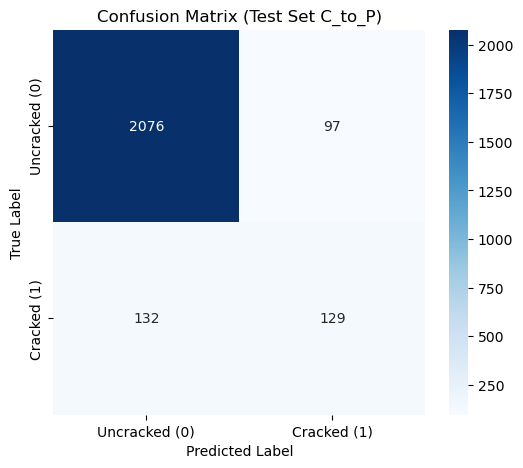

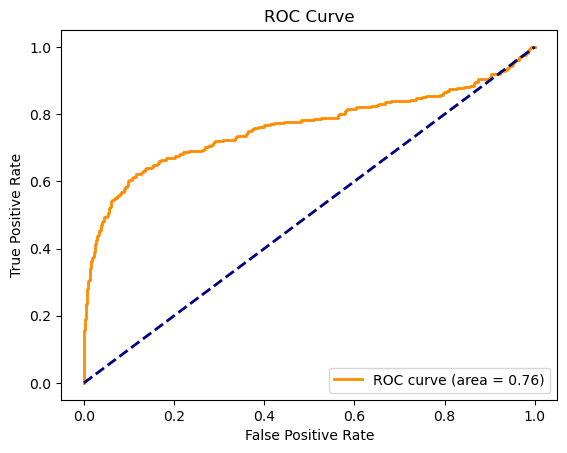

In [21]:
# Loop over each training set
for train_set in training_sets:
    train_set_name = train_set['name']
    train_gen = train_set['gen']
    train_labels = train_set['labels']

    # No need to compute class weights
    # class_weights = get_class_weights(train_labels)

    # Loop over each testing set
    for test_set in testing_sets:
        test_set_name = test_set['name']
        test_gen = test_set['gen']
        test_labels = test_set['labels']

        set_name = f'{train_set_name}_to_{test_set_name}'

        print(f'\nTraining on set {train_set_name} and testing on set {test_set_name}')

        # Call the train_and_evaluate function without class weights
        train_and_evaluate(
            train_gen=train_gen,
            test_gen=test_gen,
            train_labels=train_labels,
            test_labels=test_labels,
            set_name=set_name,
            batch_size=16,  # Adjust batch size if necessary
            alpha=1,     # Adjust alpha as needed
            gamma=0.0       # Adjust gamma as needed
        )

